<a href="https://colab.research.google.com/github/ohaanika/attention-interpretability/blob/master/retain2/retain_simple_Aanika.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### initialization

In [1]:
!git clone https://github.com/ohaanika/attention-interpretability.git
%cd attention-interpretability/retain2

Cloning into 'attention-interpretability'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 692 (delta 7), reused 16 (delta 6), pack-reused 674
Receiving objects: 100% (692/692), 128.16 MiB | 12.38 MiB/s, done.
Resolving deltas: 100% (405/405), done.
Checking out files: 100% (163/163), done.
/content/attention-interpretability/retain2


In [2]:
!git pull

Already up to date.


In [0]:
# !pip install git+https://github.com/avolkov1/keras_experiments/
# !pip install keras-self-attention

In [2]:
import os 
import re
import math
import pickle as pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import nltk
from nltk import tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model, Model
from keras import layers as L
from keras import backend as K
from keras.regularizers import l2
from keras.constraints import Constraint
from keras.callbacks import ModelCheckpoint, Callback
from keras.utils import plot_model

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


Using TensorFlow backend.


In [0]:
class Arguments():
    def __init__(self, dataset, dir_data, dir_model):
        # directories
        self.directory = {
            'data': dir_data,
            'model': dir_model
        }
        # paths
        self.path = {
            'data_raw': os.path.join('..', dir_data, dataset, dataset+'.txt'),
            'data_clean': os.path.join(dir_data, dataset, dataset+'.pkl'),
            'data_train': os.path.join(dir_data, dataset, 'data_train.pkl'),
            'data_test': os.path.join(dir_data, dataset, 'data_test.pkl'),
            'target_train': os.path.join(dir_data, dataset, 'target_train.pkl'),
            'target_test': os.path.join(dir_data, dataset, 'target_test.pkl'),
            'dictionary': os.path.join(dir_data, dataset, 'dictionary.pkl'),
            'model': os.path.join(dir_model, 'weights.01.hdf5'),
            'model_plot': os.path.join(dir_model, 'model.png'),
        }
        # vocabulary ids
        self.pad_id = 0
        self.oov_id = 1
        # number of words in vocabulary i.e. self.max_features? self.num_codes?
        self.num_codes = 150850
        self.max_features = 150850
        # maximum number of sentences/words after which the data is truncated i.e. self.n_steps?
        self.num_sentences = 50
        self.num_words = 50
        # size of embedding layer
        self.emb_size = 200 
        # size of recurrent layers
        self.recurrent_size = 200 
        # batch size
        self.batch_size = 128
        # dropout rate for embedding
        self.dropout_input = 0.0 
        # dropout rate for context vector
        self.dropout_context = 0.0 
        # L2 regularitzation value
        self.l2 = 0.0
        # number of epochs
        self.epochs = 1

# note arguments
ARGS = Arguments(dataset='IMDB', dir_data='data', dir_model='model')

### preprocess

In [6]:
def read_data():
    # read raw data from .txt file
    data = pd.read_csv(ARGS.path['data_raw'], sep='\t', header=None)
    # name columns
    data.columns = ['review', 'target']
    return data

def clean_data(data):
    stop_words = stopwords.words('english')
    lemmatizer = WordNetLemmatizer()
    # parse through reviews in data
    clean_data = []
    for review in data:
        # remove html tags
        review = re.sub(re.compile('<.*?>'), '\n', review)
        # tokenize review into sentences
        review = tokenize.sent_tokenize(review)
        # parse through sentences in review
        clean_review = []
        for sentence in review:
            # convert to lowercase
            sentence = sentence.lower()
            # keep only alphanumeric and space characters
            sentence = re.sub(r'[^\w\s]', '', sentence)
            # remove numeric characters
            sentence = re.sub(r'[0-9]+', '', sentence)
            # remove spaces at start and end of sentences
            sentence = sentence.strip()
            # replace all whitespaces and newlines with one space character
            sentence = re.sub(r'\s+', ' ', sentence)
            # tokenize sentence into words
            tokenizer = RegexpTokenizer(r'\w+')
            tokens = tokenizer.tokenize(sentence)
            # remove stop words
            filtered_words = [w for w in tokens if len(w) > 2 if not w in stop_words]
            # lemmatize words
            lemmatized_words = [lemmatizer.lemmatize(w) for w in filtered_words]
            # concatenate words into sentence
            clean_sentence = ' '.join(lemmatized_words)
            # append clean sentence if its list is not empty
            if len(clean_sentence):
                clean_review.append(clean_sentence)
        # append clean review
        clean_data.append(clean_review)
    return clean_data

def pickle_data_clean(data):
    data.drop(['review'], axis=1)
    pd.to_pickle(data, ARGS.path['data_clean'])
    print('\nData frame size: ' + str(data.shape[0]))
    print('\nData frame:')
    print(data.head())

print('>>> Reading data')
df = read_data()
print('\nExample review before any preprocessing:')
print(df['review'][3])

print('\n>>> Cleaning data')
df['codes'] = clean_data(df['review'])
print('\nExample review after cleaning:')
print(df['codes'][3])

print('\n>>> Pickling clean data')
pickle_data_clean(df)

>>> Reading data

Example review before any preprocessing:
It's a strange feeling to sit alone in a theater occupied by parents and their rollicking kids. I felt like instead of a movie ticket, I should have been given a NAMBLA membership.<br /><br />Based upon Thomas Rockwell's respected Book, How To Eat Fried Worms starts like any children's story: moving to a new town. The new kid, fifth grader Billy Forrester was once popular, but has to start anew. Making friends is never easy, especially when the only prospect is Poindexter Adam. Or Erica, who at 4 1/2 feet, is a giant.<br /><br />Further complicating things is Joe the bully. His freckled face and sleeveless shirts are daunting. He antagonizes kids with the Death Ring: a Crackerjack ring that is rumored to kill you if you're punched with it. But not immediately. No, the death ring unleashes a poison that kills you in the eight grade.<br /><br />Joe and his axis of evil welcome Billy by smuggling a handful of slimy worms into his 

In [7]:
def read_data():
    # read clean data from .pkl file
    data = pd.read_pickle(ARGS.path['data_clean'])
    return data

def split_data(df):
    splits = {}
    target = pd.DataFrame(data = np.asarray(df['target']), columns=['target'])
    data = pd.DataFrame(data = np.asarray(df['codes']), columns=['codes'])
    splits['data_train'], splits['data_test'], splits['target_train'], splits['target_test'] = train_test_split(data, target, test_size=0.3, random_state=7)
    return splits

def encode_data(splits):
    # initialize tokenizer
    tokenizer = Tokenizer(oov_token='<OOV>')
    # initialize data
    data_train = splits['data_train']['codes']
    data_test = splits['data_test']['codes']
    # create internal vocabulary based on train data
    flat_data_train = [sentence for review in data_train for sentence in review]
    tokenizer.fit_on_texts(flat_data_train)
    # transform each sentence in review to a sequence of integers
    encoded_data_train = data_train.map(lambda s: tokenizer.texts_to_sequences(s))
    encoded_data_test = data_test.map(lambda s: tokenizer.texts_to_sequences(s))
    # convert dictionary to desired format
    word2id = tokenizer.word_index
    word2id['<PAD>'] = ARGS.pad_id
    word2id = sorted(word2id.items(), key=lambda x: x[1])
    id2word = {id: word for word, id in word2id}
    # replace data with encoded data
    splits['data_train']['codes'] = encoded_data_train
    splits['data_test']['codes'] = encoded_data_test
    return splits, id2word

def pad_data(splits):
    # initialize data (train and test combined) as a list
    data_both = splits['data_train']['codes'].tolist() + splits['data_test']['codes'].tolist()
    # note maximum number of sentences in a review / words in a sentence
    list_num_sentences = [len(review) for review in data_both]
    max_num_sentences = max(list_num_sentences)
    print('\nMaximum number of sentences in a review: ' + str(max_num_sentences))
    print(sorted(list_num_sentences, reverse=True))
    list_num_words = [len(sentence) for review in data_both for sentence in review]
    max_num_words = max(list_num_words)
    print('\nMaximum number of words in a sentence: ' + str(max_num_words))
    print(sorted(list_num_words, reverse=True))
    # note desired maximum number of sentences in a review / words in a sentence
    print('\nSet number of sentences in a review after which the data will be truncated: ' + str(ARGS.num_sentences))    
    print('Set number of words in a sentence after which the data will be truncated: ' + str(ARGS.num_words))
    # pad reviews to meet desired maximum number of sentences in a review / words in a sentence
    for split in ['data_train', 'data_test']:
        data = splits[split]['codes']
        padded_data = []
        for review in data:
            # TODO: decide if we want to pad/truncate post or pre
            padded_sentences = pad_sequences(review, maxlen=ARGS.num_words, value=ARGS.pad_id,
                                             padding='post', truncating='post').tolist()
            if len(padded_sentences) > 50:
                padded_review = padded_sentences[:50]
            else:
                empty_sentences = [[0] * ARGS.num_words for i in range(ARGS.num_sentences-len(padded_sentences))]
                padded_review = padded_sentences + empty_sentences
            padded_data.append(padded_review)
        splits[split]['codes'] = padded_data
    return splits

def pickle_dictionary(dictionary):
    pd.to_pickle(dictionary, ARGS.path['dictionary'])
    print('\nDictionary size: ' + str(len(dictionary)))
    print('\nFirst ten examples from "dictionary":')
    dictionary_head = {k: dictionary[k] for k in list(dictionary)[:10]}
    print(dictionary_head)

def pickle_splits(splits):
    for split in splits.keys():
        pd.to_pickle(splits[split], ARGS.path[split])
        print('\nData frame for "' + split + '.pkl":')
        print(splits[split].head())

print('>>> Reading clean data')
df = read_data()

print('\n>>> Splitting data into train/test')
df_splits = split_data(df)

print('\n>>> Encoding data')
print('\nExample review before encoding:')
print(df_splits['data_train']['codes'][3])
df_splits, dictionary = encode_data(df_splits)
print('\nExample review after encoding:')
print(df_splits['data_train']['codes'][3])

print('\n>>> Padding data')
df_splits = pad_data(df_splits)

print('\n>>> Pickling dictionary')
pickle_dictionary(dictionary)

print('\n>>> Pickling data splits')
pickle_splits(df_splits)

>>> Reading clean data

>>> Splitting data into train/test

>>> Encoding data

Example review before encoding:
['strange feeling sit alone theater occupied parent rollicking kid', 'felt like instead movie ticket given nambla membership', 'based upon thomas rockwell respected book eat fried worm start like childrens story moving new town', 'new kid fifth grader billy forrester popular start anew', 'making friend never easy especially prospect poindexter adam', 'erica foot giant', 'complicating thing joe bully', 'freckled face sleeveless shirt daunting', 'antagonizes kid death ring crackerjack ring rumored kill youre punched', 'immediately', 'death ring unleashes poison kill eight grade', 'joe axis evil welcome billy smuggling handful slimy worm thermos', 'discovered billy play cool swearing eats worm time', 'throw joes face', 'ewww', 'win billy reluctantly bet eat worm', 'fried boiled marinated hot sauce squashed spread peanut butter sandwich', 'meal dubbed exotic name like radioactive 

### train

In [8]:
def read_data():
    def convert_input(data):
        return np.asarray(data)
    def convert_output(data):
        data = [[[target]] for target in data]
        return np.asarray(data)
    # read data from given paths
    x_train = convert_input(pd.read_pickle(ARGS.path['data_train'])['codes'].tolist())
    x_test = convert_input(pd.read_pickle(ARGS.path['data_test'])['codes'].tolist())
    y_train = convert_output(pd.read_pickle(ARGS.path['target_train'])['target'].tolist())
    y_test = convert_output(pd.read_pickle(ARGS.path['target_test'])['target'].tolist())
    return x_train, y_train, x_test, y_test

print('>>> Reading data as numpy arrays')
x_train, y_train, x_test, y_test = read_data()
print('\nShape of "x_train": ' + str(x_train.shape))
print('Shape of "y_train": ' + str(y_train.shape))
print('Shape of "x_test": ' + str(x_test.shape))
print('Shape of "y_test": ' + str(y_test.shape))

>>> Reading data as numpy arrays

Shape of "x_train": (35000, 50, 50)
Shape of "y_train": (35000, 1, 1)
Shape of "x_test": (15000, 50, 50)
Shape of "y_test": (15000, 1, 1)


In [0]:
class FreezePadding(Constraint):
    '''Freezes the last weight to be near 0.'''
    def __call__(self, w):
        other_weights = K.cast(K.ones(K.shape(w))[:-1], K.floatx())
        last_weight = K.cast(K.equal(K.reshape(w[-1, :], (1, K.shape(w)[1])), 0.), K.floatx())
        appended = K.concatenate([other_weights, last_weight], axis=0)
        w *= appended
        return w

In [12]:
def define_model():
    # note contants
    embeddings_constraint = FreezePadding()
    beta_activation = 'tanh'
    output_constraint = None
    # define inputs and sequential embedding/lambda/dropout layers
    codes = L.Input(
        shape=(None, None), 
        name='codes')
    codes_embs_total = L.Embedding(
        input_dim=ARGS.num_codes+1,
        output_dim=ARGS.emb_size,
        embeddings_constraint=embeddings_constraint,
        name='embedding')(codes)
    codes_embs = L.Lambda(
        function=lambda x: K.sum(x, axis=2),
        name='lambda_1')(codes_embs_total)
    codes_embs = L.Dropout(
        rate=ARGS.dropout_input,
        name='dropout_1')(codes_embs)
    # define alpha layer to compute sentence level attention
    alpha = L.Bidirectional(
        layer=L.CuDNNLSTM(
            ARGS.recurrent_size, 
            return_sequences=True), 
        name='alpha')(codes_embs)
    alpha_dense = L.TimeDistributed(
        layer=L.Dense(
            units=1, 
            kernel_regularizer=l2(ARGS.l2)), 
        name='alpha_dense')(alpha)
    alpha_softmax = L.Softmax(
        axis=1,
        name='alpha_softmax')(alpha_dense)
    # define beta layer to compute word level attention
    beta = L.Bidirectional(
        layer=L.CuDNNLSTM(
            ARGS.recurrent_size, 
            return_sequences=True), 
        name='beta')(codes_embs)
    beta_dense = L.TimeDistributed(
        L.Dense(
            units=ARGS.emb_size, 
            activation=beta_activation, 
            kernel_regularizer=l2(ARGS.l2)), 
        name='beta_dense')(beta)
    # define context layers to compute context vector based on attentions and embeddings
    c_t = L.Multiply(
        name='multiply')([codes_embs, alpha_softmax, beta_dense])
    c_t = L.Lambda(
        function=lambda x: K.sum(x, axis=1),
        name='lambda_2')(c_t)
    # reshape context vectors to 3d vector for consistency between Many to Many and Many to One implementations
    contexts = L.Lambda(
        function=lambda x: K.reshape(x, shape=(K.shape(x)[0], 1, 200)), # TODO: ARGS.emb_size = 200
        name='lambda_3')(c_t)
    # define dropout layer to make a prediction
    contexts = L.Dropout(
        rate=ARGS.dropout_context,
        name='dropout_2')(contexts)
    # TimeDistributed is used for consistency between Many to Many and Many to One implementations
    output = L.TimeDistributed(
        layer=L.Dense(
            units=1, 
            activation='sigmoid', 
            name='dOut', 
            kernel_regularizer=l2(ARGS.l2),
            kernel_constraint=output_constraint), 
        name='time_distributed')(contexts)
    # define the model with appropriate inputs and outputs
    model = Model(inputs=[codes], outputs=[output])
    # compile model 
    model.compile(
        optimizer='adamax',
        loss='binary_crossentropy',
        metrics=['accuracy'],
        sample_weight_mode='temporal')
    # visually inspect architecture of model
    model.summary()
    return model

print('>>> Create a model to take codes as input, targets as output')
model = define_model()

# TODO: pick best optimizer/loss/etc when compiling
# https://keras.io/models/model/#compile
# https://keras.io/optimizers/
# https://keras.io/losses/
# adamax has produced best results in RETAIN experiments

>>> Create a model to take codes as input, targets as output
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
codes (InputLayer)              (None, None, None)   0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, None, 2 30170200    codes[0][0]                      
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, None, 200)    0           embedding[0][0]                  
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, None, 200)    0           lambda_1[0][0]                   
_______________________________

>>> Saving model architecture as model/model.png


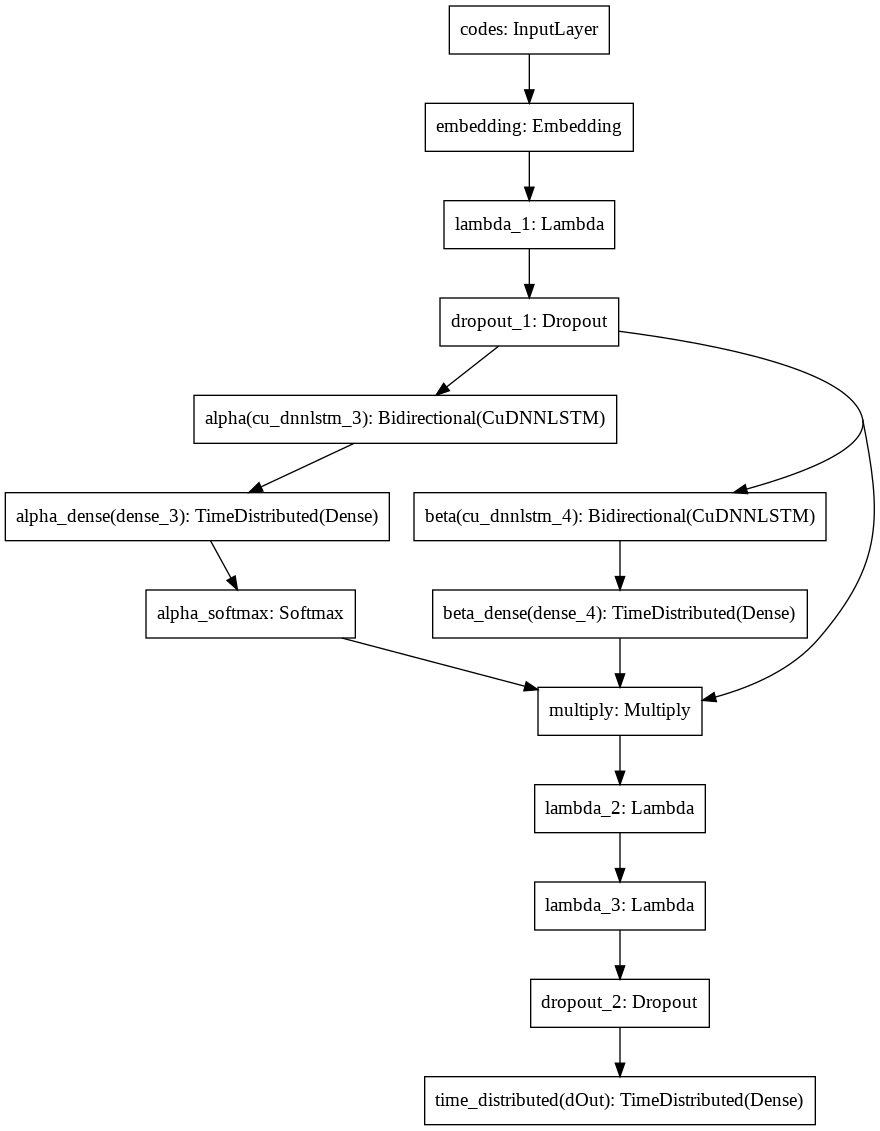

In [13]:
print('>>> Saving model architecture as ' + ARGS.path['model_plot'])
plot_model(model, to_file=ARGS.path['model_plot'])

In [14]:
print('>>> Fitting model')
checkpoint = ModelCheckpoint(filepath=os.path.join(ARGS.directory['model'], 'weights.{epoch:02d}.hdf5'))
history = model.fit(x_train, y_train, epochs=ARGS.epochs, batch_size=ARGS.batch_size, callbacks=[checkpoint])

# TODO: implement validation split to pick epochs, batch_size, and more!
# https://keras.io/models/model/#fit

>>> Fitting model



Epoch 1/1





35000/35000 [==============================] - 48s 1ms/step - loss: 0.5573 - acc: 0.7489


In [15]:
# compute loss and accuracy for train set
result = model.evaluate(x_train, y_train)
print(result)

35000/35000 [==============================] - 23s 652us/step
[0.3101415705680847, 0.8706000000136239]


In [16]:
# compute loss and accuracy for test set
result = model.evaluate(x_test, y_test)
print(result)

15000/15000 [==============================] - 10s 641us/step
[0.3512206239859263, 0.8487999999682109]


### attention

In [5]:
def read_data():
    def convert_input(data):
        return np.asarray(data)
    def convert_output(data):
        data = [[[target]] for target in data]
        return np.asarray(data)
    # read data from given paths
    x_train = convert_input(pd.read_pickle(ARGS.path['data_train'])['codes'].tolist())
    x_test = convert_input(pd.read_pickle(ARGS.path['data_test'])['codes'].tolist())
    y_train = convert_output(pd.read_pickle(ARGS.path['target_train'])['target'].tolist())
    y_test = convert_output(pd.read_pickle(ARGS.path['target_test'])['target'].tolist())
    # read dictionary from given path
    with open(ARGS.path['dictionary'], 'rb') as f:
        dictionary = pickle.load(f)
    return x_train, y_train, x_test, y_test, dictionary

def import_model(path):
    # prepare tensorflow session
    K.clear_session()
    config = tf.compat.v1.ConfigProto(allow_soft_placement=True, log_device_placement=False)
    config.gpu_options.allow_growth = True
    tfsess = tf.compat.v1.Session(config=config)
    K.set_session(tfsess)
    # import model from given path
    model = load_model(path, custom_objects={'FreezePadding': FreezePadding})
    model_with_attention = Model(model.inputs, model.outputs +\
                                              [model.get_layer(name='dropout_1').output,\
                                               model.get_layer(name='alpha_softmax').output,\
                                               model.get_layer(name='beta_dense').output])
    return model, model_with_attention

def get_model_parameters(model):
    # extract model arguments that were used during training
    class ModelParameters:
        # helper class to store model parameters in the same format as ARGS
        def __init__(self):
            self.num_codes = None
            self.emb_weights = None
            self.output_weights = None
            self.bias = None
    params = ModelParameters()
    params.num_codes = model.get_layer(name='embedding').input_dim-1
    params.emb_weights = model.get_layer(name='embedding').get_weights()[0]
    params.output_weights, params.bias = model.get_layer(name='time_distributed').get_weights()
    print('\nModel bias: {}'.format(params.bias))
    return params

print('>>> Reading dictionary and data as numpy arrays')
x_train, y_train, x_test, y_test, dictionary = read_data()
print('\nShape of "x_train": ' + str(x_train.shape))
print('Shape of "y_train": ' + str(y_train.shape))
print('Shape of "x_test": ' + str(x_test.shape))
print('Shape of "y_test": ' + str(y_test.shape))

print('\n>>> Loading original model')
model, model_with_attention = import_model(ARGS.path['model'])

print('\n>>> Extracting parameters of original')
model_parameters = get_model_parameters(model)

>>> Reading dictionary and data as numpy arrays


FileNotFoundError: ignored

In [18]:
def define_submodel(model_old):
    # take dropout_1, alpha_softmax, beta_dense from old model as inputs for new model 
    new_inputs = []
    for layer_name in ['dropout_1', 'alpha_softmax', 'beta_dense']:
        new_inputs.append(L.Input(
            shape=model_old.get_layer(layer_name).output_shape[1:],
            name=layer_name))
    # stack sequential layers until output from old model
    output = new_inputs
    for layer_name in ['multiply', 'lambda_2', 'lambda_3', 'dropout_2', 'time_distributed']:
        layer = model_old.get_layer(layer_name)
        output = layer(output)
    new_outputs = [output]
    # define the model with appropriate inputs and outputs
    model_new = Model(inputs=new_inputs, outputs=new_outputs)
    # compile new model 
    model_new.compile(
        optimizer='adamax',
        loss='binary_crossentropy',
        metrics=['accuracy'],
        sample_weight_mode='temporal')
    # visually inspect architecture of new model
    print()
    print(model_new.summary())
    return model_new

print('>>> Create a new model with attention layer (softmax_1, beta_dense_0, dropout_1) as inputs')
submodel = define_submodel(model)

>>> Create a new model with attention layer (softmax_1, beta_dense_0, dropout_1) as inputs

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dropout_1 (InputLayer)          (None, None, 200)    0                                            
__________________________________________________________________________________________________
alpha_softmax (InputLayer)      (None, None, 1)      0                                            
__________________________________________________________________________________________________
beta_dense (InputLayer)         (None, None, 200)    0                                            
__________________________________________________________________________________________________
multiply (Multiply)             (None, None, 200)    0           dropout_1[0][0]                  


In [19]:
print('>>> Predicting probabilities with original model')
y_pred = model.predict(x_test)
y_pred = [pred[0][0] for pred in y_pred]
y_pred_binary = [int(round(pred)) for pred in y_pred]
print('\nPredictions (float):')
print(y_pred)
print('\nPredictions (int):')
print(y_pred_binary)

print('\n>>> Gather attention weights from original model to feed as input for new submodel')
y_pred, drops, alphas, betas = model_with_attention.predict(x_test)
print('\nShapes of y_pred, drops, alphas, betas respectively:')
print(y_pred.shape, drops.shape, alphas.shape, betas.shape)

print('\n>>> Predicting probabilities with new submodel (without modifying attention weights)')
y_pred = submodel.predict([drops, alphas, betas])
y_pred = [pred[0][0] for pred in y_pred]
y_pred_binary = [int(round(pred)) for pred in y_pred]
print('\nPredictions (float):')
print(y_pred)
print('\nPredictions (int):')
print(y_pred_binary)

>>> Predicting probabilities with original model

Predictions (float):
[0.83381045, 0.8985163, 0.016198397, 0.20588696, 0.7604674, 0.7527355, 0.42271754, 0.6322551, 0.61709654, 0.9200434, 0.028176636, 0.20266262, 0.839141, 0.97986877, 0.6795798, 0.9537081, 0.029862493, 0.84903693, 0.75564855, 0.5859039, 0.12885806, 0.140778, 0.9833135, 0.9849987, 0.112434566, 0.70867974, 0.6771377, 0.07149613, 0.94130504, 0.6701919, 0.9432044, 0.8355346, 0.039435774, 0.019577801, 0.70699304, 0.5953099, 0.92172825, 0.04052487, 0.59287214, 0.11465892, 0.5498716, 0.1905708, 0.028738022, 0.624248, 0.96354026, 0.75622857, 0.9288751, 0.15857172, 0.49644434, 0.87161034, 0.08510187, 0.9639722, 0.9047351, 0.9233333, 0.8981463, 0.95051455, 0.60899365, 0.8455887, 0.9277681, 0.09055072, 0.08200374, 0.88436884, 0.2069912, 0.85685503, 0.049681515, 0.88105404, 0.654873, 0.047969103, 0.7203897, 0.68814313, 0.20428884, 0.1301432, 0.93532765, 0.8589052, 0.88479817, 0.8606775, 0.97872746, 0.7609167, 0.5263424, 0.8418225,

In [0]:
# new_df = pd.DataFrame()
# new_df['tokens'] = x_test.tolist()
# new_df['preds'] = y_pred
# new_df['drops'] = drops.tolist()
# new_df['alphas'] = alphas.tolist()
# new_df['betas'] = betas.tolist()
# print(new_df.head())

# probability = []
# review_dict = {}
# new_dict = {}
# for i in range(1):
#     probability.append(probabilities[i, 0, 0])
#     patient_data = data_generator.__getitem__(i)
#     proba, alphas, betas = model_with_attention.predict_on_batch(patient_data)
#     visits, new_a, new_b = get_importances(alphas[0], betas[0], patient_data, model_parameters, dictionary)
#     review_dict[str(i)] = visits
#     new_visits = get_importances(new_a[0], new_b[0], patient_data, model_parameters, dictionary)
#     new_dict[str(i)] = new_visits

In [0]:

for i in range(1):
    # get y_pred, alpha, beta for each review directly from submodel
    p = y_pred[i]
    a = alphas[i]
    b = betas[i]
    # transform (alpha, beta) representations to map to each (sentence, word) respectively
    # ...
    # 

### archive

In [0]:
# from keras.datasets import imdb
# from keras.preprocessing import sequence
# from keras.layers import Dense, Embedding, LSTM, Bidirectional

In [0]:
# (x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=ARGS.max_features)

# print(type(x_train), x_train.shape)
# print(type(y_train), y_train.shape)
# print(type(x_test), x_test.shape)
# print(type(y_test), y_test.shape)
# print()
# print(len(x_train[0]))
# print(len(x_train[1]))
# print(x_train[1])
# print(type(x_train[1]))
# print(y_train[1])
# print(type(y_train[1]))

In [0]:
# (x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=ARGS.max_features)
# x_train = sequence.pad_sequences(x_train, maxlen=ARGS.max_len)
# x_test = sequence.pad_sequences(x_test, maxlen=ARGS.max_len)

In [0]:
# import os
# import numpy as np
# import pandas as pd
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.python.keras.datasets import imdb
# from tensorflow.python.keras.preprocessing import sequence
# from tensorflow.python.keras import models
# from tensorflow.python.keras import layers
# from tensorflow.python.keras import Input
# from tensorflow.python.keras.layers import Dense, Embedding, LSTM, Bidirectional
# from keras_self_attention import SeqSelfAttention, SeqWeightedAttention

# vocab_size = 10000
# pad_id = 0
# start_id = 1
# oov_id = 2
# index_offset = 2
 
# (x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(
#     num_words=vocab_size, start_char=start_id, 
#     oov_char=oov_id, index_from=index_offset)
 
# word2idx = tf.keras.datasets.imdb.get_word_index()
# word2idx['<PAD>'] = pad_id
# word2idx['<START>'] = start_id
# word2idx['<OOV>'] = oov_id
# word2idx = sorted(word2idx.items(), key=lambda x: x[1])
# idx2word = {index: word for word, index in word2idx}
 
# max_len = 200
# rnn_cell_size = 128
 
# x_train = sequence.pad_sequences(x_train, maxlen=max_len, truncating='post', padding='post', value=pad_id)
# x_test = sequence.pad_sequences(x_test, maxlen=max_len, truncating='post', padding='post', value=pad_id)

# print(x_train.shape)
# print(y_train.shape)
# print(x_test.shape)
# print(y_test.shape)
# print(len(x_train[0]))
# print(len(x_train[1]))
# print(x_train[1])
# print(type(x_train[1]))
# print(y_train[1])
# print(type(y_train[1]))